<a href="https://colab.research.google.com/github/DvirHayat/IntroToCloud/blob/main/HW2/ManagerDash_sloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [1]:
!pip install matplotlib pandas firebase

### Imports

In [2]:
import pandas as pd
import json
import ipywidgets as widgets
from IPython.display import display, clear_output ,HTML
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from firebase import firebase

### File selction - choose json file at run time or group file from firebase

#### Our team JSON file (stored in firebase)

In [3]:
# Initialize Firebase application
firebase_app = firebase.FirebaseApplication('https://cloudcourse-79588-default-rtdb.europe-west1.firebasedatabase.app/', None)

# Fetch data from Firebase
result = firebase_app.get('/', None)

# Save the result as a JSON file
with open('firebase_data.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)

print("Data saved to firebase_data.json")

# Read JSON file into DataFrame
filename='firebase_data.json'

Data saved to firebase_data.json


#### Generic suitable JSON file selection (JSON OnShape formatted)
filename and data frame will be determened by user selection:
> cancel upload - firebase JSON file (our group file)

> upload succeeded -file uploaded from device




In [8]:
from google.colab import files
try:
  uploaded = files.upload()
  # Get the filename from the uploaded dictionary
  filename = list(uploaded.keys())[0]
except:
  print("firebase data selected")
finally:
  data = pd.read_json(filename)

firebase data selected


### General data cleansing and transforming

In [5]:

df = pd.DataFrame(data)
df['Time'] = pd.to_datetime(df['Time'])

# Extract date and hour from 'Time' column
df['Date'] = df['Time'].dt.date
df['Hour'] = df['Time'].dt.hour

df.set_index('Time', inplace=True)

### View Project related data - learning curve, attention graph
#### Added feature - export selected graph to PDF

Dropdown(description='Document:', index=9, options=('Whole Project', 'Industry 4.0 Project', 'Part Studio 1 Co…

Dropdown(description='Data Type:', index=1, options=('Learning Curve', 'Working Hours'), value='Working Hours'…

Dropdown(description='User:', index=1, options=('All Users', 'StudentA1', 'StudentA2', 'StudentA3'), value='St…

Dropdown(description='Graph Type:', options=('Bar',), value='Bar')

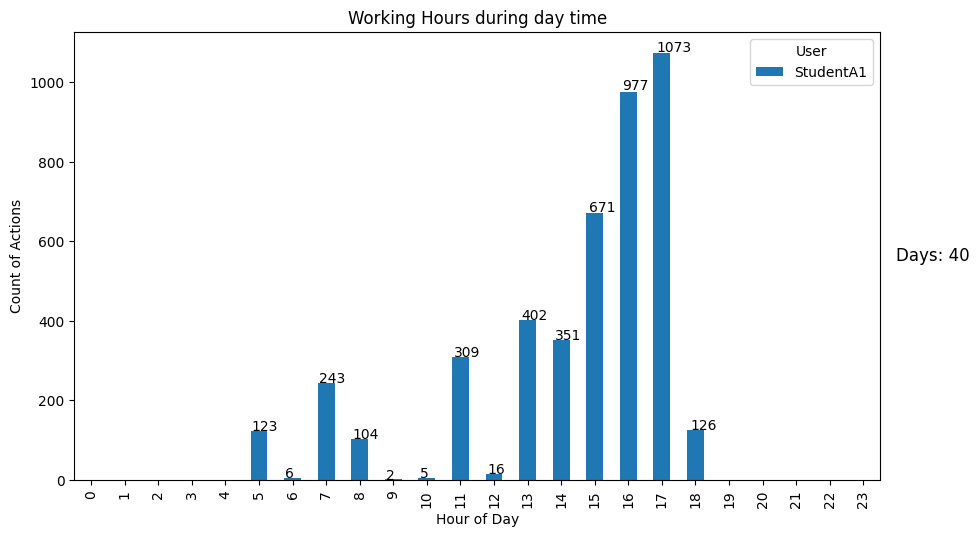

Button(description='Export to PDF', style=ButtonStyle())

In [6]:
# Create dropdowns for selecting document, data type, user, and graph type
doc_dropdown = widgets.Dropdown(
    options=['Whole Project'] + df['Document'].unique().tolist(),
    value='Whole Project',
    description='Document:',
)

data_type_dropdown = widgets.Dropdown(
    options=['Learning Curve', 'Working Hours'],
    value='Learning Curve',
    description='Data Type:',
)

user_dropdown = widgets.Dropdown(
    options=['All Users'] + df['User'].unique().tolist(),
    value='All Users',
    description='User:',
)

graph_type_dropdown = widgets.Dropdown(
    options=['Line'],
    value='Line',
    description='Graph Type:',
)

# Global figure object
global_fig = None

# Function to update the graph type options based on data type and user
def update_graph_type_options(data_type, user):
    if data_type == 'Learning Curve':
        graph_type_dropdown.options = ['Line']
    elif data_type == 'Working Hours':
        if user == 'All Users':
            graph_type_dropdown.options = ['Bar', 'Pie']
        else:
            graph_type_dropdown.options = ['Bar']
    graph_type_dropdown.value = graph_type_dropdown.options[0]

# Function to plot learning curve
def plot_learning_curve(filtered_df):
    global global_fig
    global_fig, ax = plt.subplots(figsize=(10, 6))
    undo_counts = filtered_df[filtered_df['Description'].str.contains('undo', case=False)].resample('D').size()
    redo_counts = filtered_df[filtered_df['Description'].str.contains('redo', case=False)].resample('D').size()
    delete_counts = filtered_df[filtered_df['Description'].str.contains('delete', case=False)].resample('D').size()

    num_days = (filtered_df.index.max() - filtered_df.index.min()).days + 1

    if not undo_counts.empty:
        ax.plot(undo_counts.index, undo_counts, marker='o', label='Undo Actions')
    if not redo_counts.empty:
        ax.plot(redo_counts.index, redo_counts, marker='o', label='Redo Actions')
    if not delete_counts.empty:
        ax.plot(delete_counts.index, delete_counts, marker='o', label='Delete Actions')

    ax.set_title('Learning Curve (Count of Undo, Redo, and Delete Actions)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count of Actions')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.text(1.02, 0.5, f'Days: {num_days}', transform=ax.transAxes, fontsize=12, verticalalignment='center')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Add space for the title and Days text
    plt.subplots_adjust(top=0.85)  # Adjust the top margin for spacing
    plt.show()
    display(export_button)

# Function to plot working hours
def plot_working_hours(filtered_df, graph_type):
    global global_fig
    global_fig, ax = plt.subplots(figsize=(10, 6))
    filtered_df = filtered_df.copy()  # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    filtered_df['Hour'] = filtered_df.index.hour
    working_time = filtered_df.groupby(['Hour', 'User']).size().unstack(fill_value=0)
    hours = range(24)
    working_time = working_time.reindex(hours, fill_value=0)

    non_zero_cols = working_time.columns[(working_time != 0).any()]
    working_time = working_time[non_zero_cols]

    num_days = (filtered_df.index.max() - filtered_df.index.min()).days + 1

    if graph_type == 'Bar':
        working_time.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title('Working Hours during day time')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Count of Actions')
        ax.set_xticks(hours)
        ax.legend(title='User')

        for p in ax.patches:
            if p.get_height() > 0:
                ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

    elif graph_type == 'Pie':
        user_sums = working_time.sum(axis=0)
        if user_sums.sum() == 0:
            print("No data available to display.")
            return
        user_sums.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90)
        ax.set_ylabel('')
        ax.set_title('Working Hours during day time')

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Add space for the title and Days text
    if graph_type == 'Pie':
        ax.text(1.3, 0.5, f'Days: {num_days}', transform=ax.transAxes, fontsize=12, verticalalignment='center')
    else:
        ax.text(1.02, 0.5, f'Days: {num_days}', transform=ax.transAxes, fontsize=12, verticalalignment='center')
    plt.subplots_adjust(top=0.85)  # Adjust the top margin for spacing
    plt.show()
    display(export_button)

# Function to export the current graph to a PDF
def export_to_pdf(b):
    global global_fig
    if global_fig:
        doc = doc_dropdown.value
        data_type = data_type_dropdown.value
        user = user_dropdown.value
        export_date = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        title = f'{doc} - {data_type} - {user}\nDate of export: {export_date}'

        pdf_filename = f'{doc.lower().replace(" ", "_")}-{data_type.lower().replace(" ", "_")}-{user.lower().replace(" ", "_")}.pdf'

        with PdfPages(pdf_filename) as pdf:
            # Add title to the figure
            global_fig.suptitle(title, x=0.4, y=1.05, fontsize=14)
            pdf.savefig(global_fig, bbox_inches='tight')
            print(f"Graph exported to {pdf_filename}")
    else:
        print("No graph to export.")

# Create a button for exporting the graph to PDF
export_button = widgets.Button(description="Export to PDF")
export_button.on_click(export_to_pdf)

# Function to update the plot based on dropdown selections
def update_plot(doc, data_type, user, graph_type):
    if doc == 'Whole Project':
        filtered_df = df
    else:
        filtered_df = df[df['Document'] == doc]

    if user != 'All Users':
        filtered_df = filtered_df[filtered_df['User'] == user]

    if not filtered_df.empty:
        if data_type == 'Learning Curve':
            if filtered_df[filtered_df['Description'].str.contains('undo|redo|delete', case=False)].empty:
                print("No data available for the selected filters.")
            else:
                plot_learning_curve(filtered_df)
        elif data_type == 'Working Hours':
            if filtered_df.empty:
                print("No data available for the selected filters.")
            else:
                plot_working_hours(filtered_df, graph_type)
    else:
        print("No data available for the selected filters.")

# Create event handlers for dropdowns
def on_doc_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(change['new'], data_type_dropdown.value, user_dropdown.value, graph_type_dropdown.value)

def on_data_type_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_graph_type_options(change['new'], user_dropdown.value)
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(doc_dropdown.value, change['new'], user_dropdown.value, graph_type_dropdown.value)

def on_user_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_graph_type_options(data_type_dropdown.value, change['new'])
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(doc_dropdown.value, data_type_dropdown.value, change['new'], graph_type_dropdown.value)

def on_graph_type_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)
        update_plot(doc_dropdown.value, data_type_dropdown.value, user_dropdown.value, change['new'])

doc_dropdown.observe(on_doc_change)
data_type_dropdown.observe(on_data_type_change)
user_dropdown.observe(on_user_change)
graph_type_dropdown.observe(on_graph_type_change)

# Initialize graph type options based on the default data type
update_graph_type_options(data_type_dropdown.value, user_dropdown.value)

# Display the dropdowns
display(doc_dropdown, data_type_dropdown, user_dropdown, graph_type_dropdown)


### View User Related graphs:
* Activity table (actions in each relevant project)
* Top 5 most active projects
* Top 10 most common actions
* Activity in tabs of the top 3 active projects  

In [7]:
# Create user dropdown

# Define function to create user dropdown
def create_user_dropdown():
    return widgets.Dropdown(
        options=data['User'].unique(),
        description='User:',
        disabled=False,
    )

user_dropdown_1 = create_user_dropdown()
display(user_dropdown_1)

# Output widget for the table,active projects, top 10 actions
output_description_table = widgets.Output()
output_active_projects_chart = widgets.Output()
output_common_actions_chart = widgets.Output()
output_nested_pie_chart = widgets.Output()

display(output_description_table)
display(output_active_projects_chart)
display(output_common_actions_chart)
display(output_nested_pie_chart)

# Callback function to update the table
def update_description_table(user):
    user_data = data[data['User'] == user]
    description_counts = user_data['Document'].value_counts().reset_index()
    description_counts.columns = ['Document', 'Count']

    with output_description_table:
        output_description_table.clear_output()
        display(HTML(description_counts.to_html(index=False)))

# Link dropdown to the update function
def on_user_change_table(change):
    update_description_table(change['new'])

# Callback function to update the bar chart
def update_active_projects_chart(user):
    user_data = data[data['User'] == user]
    description_counts = user_data['Document'].value_counts().reset_index()
    description_counts.columns = ['Document', 'Count']

    top_active_projects = description_counts.head(5)

    with output_active_projects_chart:
        output_active_projects_chart.clear_output()
        fig, ax = plt.subplots()
        ax.bar(top_active_projects['Document'], top_active_projects['Count'], color='skyblue')
        ax.set_xlabel('Document')
        ax.set_ylabel('Count')
        ax.set_title('Top 5 Active Projects - (amount of actions)')
        plt.xticks(rotation=90)

        # Annotate each bar with its value
        for index, value in enumerate(top_active_projects['Count']):
            ax.text(index, value, str(value), ha='center', va='bottom')

        plt.show()

# Link dropdown to the update function
def on_user_change_chart(change):
    update_active_projects_chart(change['new'])
# Callback function to update the bar chart
def update_common_actions_chart(user):
    user_data = data[data['User'] == user]
    common_actions = user_data['Description'].value_counts().head(10).reset_index()
    common_actions.columns = ['Description', 'Count']

    with output_common_actions_chart:
        output_common_actions_chart.clear_output()
        fig, ax = plt.subplots()
        ax.bar(common_actions['Description'], common_actions['Count'], color='lightgreen')
        ax.set_xlabel('Action')
        ax.set_ylabel('Count')
        ax.set_title(f'10 Most Common Actions by User: {user}')
        plt.xticks(rotation=90, ha='right')

        # Annotate each bar with its value
        for index, value in enumerate(common_actions['Count']):
            ax.text(index, value, str(value), ha='center', va='bottom')

        plt.show()

# Link dropdown to the update function
def on_user_change_common_actions(change):
    update_common_actions_chart(change['new'])

# Callback function to update the nested pie chart
def update_nested_pie_chart(user):
    user_data = df[df['User'] == user]
    project_tab_counts = user_data.groupby(['Document', 'Tab']).size().reset_index(name='Count')

    top_projects = user_data['Document'].value_counts().head(3).index
    project_tab_counts = project_tab_counts[project_tab_counts['Document'].isin(top_projects)]

    projects = project_tab_counts['Document'].unique()
    tab_counts_per_project = [project_tab_counts[project_tab_counts['Document'] == project]['Count'].sum() for project in projects]

    with output_nested_pie_chart:
        output_nested_pie_chart.clear_output()
        fig, ax = plt.subplots()
        ax.pie(tab_counts_per_project, labels=projects, radius=2, wedgeprops=dict(width=0.6, edgecolor='w'),textprops={'fontsize': 10})

        tabs = project_tab_counts['Tab']
        tab_counts = project_tab_counts['Count']
        ax.pie(tab_counts, labels=tabs, radius=1, wedgeprops=dict(width=0.6, edgecolor='w'),textprops={'fontsize': 10})

        ax.set(aspect="equal", title=f'Nested Pie Chart of Tabs in Top 3 Projects for User: {user}')
        plt.show()
def on_user_change_nested_pie(change):
    update_nested_pie_chart(change['new'])

user_dropdown_1.observe(on_user_change_common_actions, names='value')
user_dropdown_1.observe(on_user_change_chart, names='value')
user_dropdown_1.observe(on_user_change_table, names='value')
user_dropdown_1.observe(on_user_change_nested_pie, names='value')

Dropdown(description='User:', options=('StudentA1', 'StudentA2', 'StudentA3'), value='StudentA1')

Output()

Output()

Output()

Output()